In [1]:
# установка и импорт библиотек
!pip install -q tensorflow==2.3
!pip install albumentations -q
!pip install pymystem3
#! pip install pymorphy2
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
import albumentations

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from tqdm import tqdm
#import pymorphy2
from string import punctuation
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# ПРОЕКТ CAR PRICE

* Шаг 1. Построим «наивную» ML-модель на табличных данных, которая предсказывает цену по модели и году выпуска. Это позволит нам задать направление для дальнейших экспериментов. Впоследствии на этом этапе вы можете доработать вашу модель из проекта «Выбираем авто выгодно».
* Шаг 2. Обработаем и отнормируем признаки и сделаем первую модель на основе градиентного бустинга с помощью CatBoost.
* Шаг 3. Решим эту же задачу с помощью DL (модель NN Tabular) и сравним результаты.
* Шаг 4. Добавим текстовые данные (NLP) и сделаем Multi-Input нейронную сеть для анализа и табличных данных, и текста одновременно.
* Шаг 5. Добавим обработку изображений в Multi-Input нейронную сеть.
* Шаг 6. Осуществим ансамблирование градиентного бустинга и нейронной сети (усредним их предсказания).

![](https://a.d-cd.net/OSOIkXrRNf4leu6chVWxvcHB2M8-960.jpg)

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [3]:
# фиксируем значения
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
x_size = 8
y_size = 5

In [4]:
def mape(y_true, y_pred):
    """функция для определения целевой метрики"""
    return np.mean(np.abs((y_pred-y_true)/y_true))

def getCountPlot(df, feature, x_s=x_size, y_s=y_size):
    """функция для построения каунтпловот для категорийных признаков"""
    plt.figure(figsize=(x_s, y_s))
    sns.countplot(data=df,
            order = df[feature].value_counts().index, 
            y=feature)
    plt.title(f'Распределение значений признака {feature}')
    plt.show;
    
def emission_replacement(df, column, method='median'):
    '''
    Заменяет выбросы в серии вычисленным значением 
    method='median' - замена на медиану
    method='average' - замена на среднее
    method ='probable' - вероятностное распределение
    '''
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if method =='median':
        df.loc[(df[column] < f) | (df[column] > l), column] = df[column].median()
    elif method =='average':
        df.loc[(df[column] < f) | (df[column] > l), column] = df[column].mean()
    elif method =='probable':
        # замена выбросов на nan 
        df[column] = np.where((df[column] < f) | (df[column] > l), np.nan, df[column])
        mask = df[column].isna()
        # статистика распределения значений
        p = df[column].value_counts() / len(df[column].dropna())
        # заполняем пропуски с вероятностью `p`
        df.loc[mask, column] = np.random.choice(p.index.to_list(),
                                            size=mask.sum(), 
                                            p=p.to_list())

In [5]:
!pip freeze > requirements.txt

# DATA

типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [6]:
# загружаем данные 
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [7]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [8]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


Точность наивной модели по метрике MAPE: 19.88%

# EDA and preproc

In [9]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [11]:
# взглянем на количество пропусков
data.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

In [12]:
# проверим на дубликаты
len(data.drop_duplicates()) - len(data)

0

## Осмотрим признаки

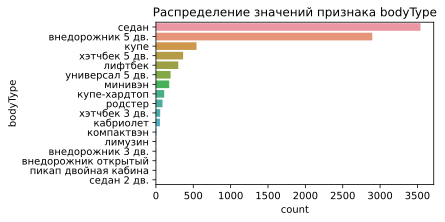

In [13]:
# bodyType
getCountPlot(data,'bodyType', 5, 3)

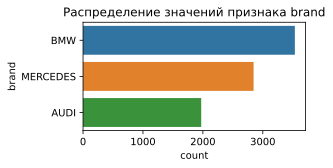

In [14]:
# brand
getCountPlot (data,'brand', 4, 2)

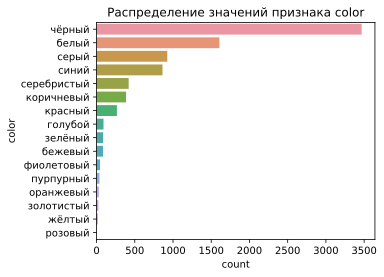

In [15]:
# color
getCountPlot(data,'color', 5, 4)

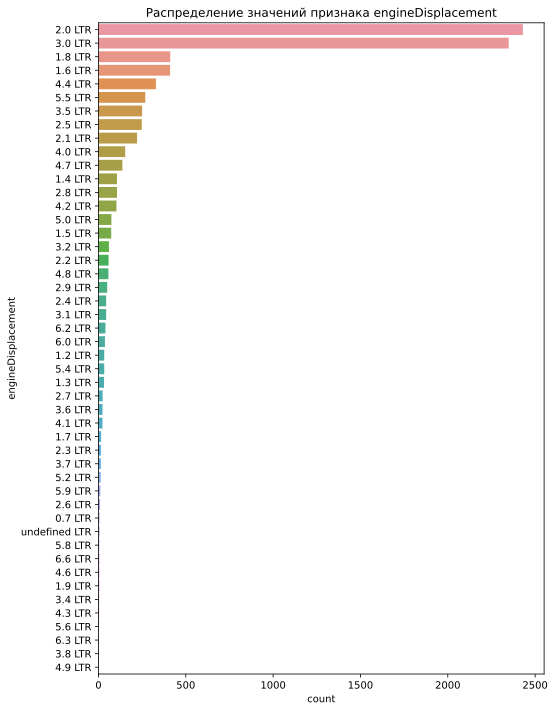

In [16]:
# engineDisplacement
getCountPlot(data,'engineDisplacement', 8, 12)

In [17]:
# извлечём цифры
data['engineDisplacement'] = data['engineDisplacement'].astype(str).apply(lambda x: x.split()[0])
# заменим неопределённость на число
data['engineDisplacement'] =  data['engineDisplacement'].replace('undefined', 0.0)
# приведём всё к одному формату
data['engineDisplacement'] = data['engineDisplacement'].astype(float)

In [18]:
# enginePower
data['enginePower'].unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

In [19]:
# извлечём цифры мощности и приведём к удобному формату
data['enginePower'] = data['enginePower'].str.split().apply(lambda x: x[0]) 
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))

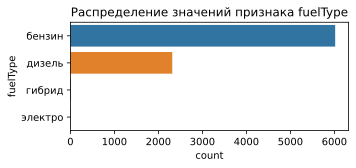

In [20]:
# fuelType
getCountPlot(data,'fuelType', 5, 2)

In [21]:
# model_info
data['model_info'].unique()

array(['W124', '6ER', '3ER', '5ER', 'Q7', 'SL_KLASSE', 'A5', 'A4',
       'GL_KLASSE', 'A6', '1ER', 'X5', 'X3', 'S_KLASSE',
       'S_CLASS_MAYBACH', 'G_KLASSE', 'E_KLASSE', 'X7', 'Q5', 'A3',
       'B_KLASSE', '4', 'CLS_KLASSE_AMG', 'RS3', 'X6', 'C_KLASSE', 'X1',
       'S8', 'Q3', 'X6_M', '7ER', 'GLS_KLASSE', 'A7', 'GLC_KLASSE', 'TT',
       'Q8', 'M3', 'M4', 'C_KLASSE_AMG', 'X4', 'G_KLASSE_AMG', 'VITO',
       'M_KLASSE', 'CLA_KLASSE', 'TTS', 'GLK_KLASSE', 'SLK_KLASSE_AMG',
       'CLS_KLASSE', 'R_KLASSE', 'S_KLASSE_AMG', 'VIANO', 'GLE_KLASSE',
       'S5', 'AMG_GT', 'A8', 'M_KLASSE_AMG', 'A_KLASSE', 'M5', 'X5_M',
       'GLE_KLASSE_COUPE_AMG', 'ALLROAD', 'GLE_KLASSE_COUPE',
       'E_KLASSE_AMG', 'GLA_CLASS', 'SLS_AMG', 'AMG_GLC_COUPE',
       'V_KLASSE', 'GLE_KLASSE_AMG', 'X2', 'A4_ALLROAD', 'CL_KLASSE',
       'SLK_KLASSE', 'CLA_KLASSE_AMG', 'RS5', 'X_KLASSE', 'W123', 'A1',
       'S6', 'M6', 'M1', '2ER', '8ER', 'RS6', 'SL_KLASSE_AMG', 'S7', 'M2',
       'CL_KLASSE_AMG', 'Z4', 'X

In [22]:
# name
data['name'].sample(10)

7399      28i xDrive 2.0 AT (245 л.с.) 4WD
4273          40e 2.0hyb AT (245 л.с.) 4WD
3362     63 AMG Long 5.5 AT (585 л.с.) 4WD
2794               3.0d AMT (245 л.с.) 4WD
5378    525d xDrive 2.0d AT (218 л.с.) 4WD
5902                 4.0 AT (560 л.с.) 4WD
1454    740Li xDrive 3.0 AT (320 л.с.) 4WD
2476                525i 2.5 AT (218 л.с.)
743                 116i 1.6 AT (115 л.с.)
1168          63 AMG 5.5 AT (544 л.с.) 4WD
Name: name, dtype: object

In [23]:
# большинство характеристик упоминаются в других столбцах
# вынесим отсюда пару признаков
data['4wd'] = data['name'].apply(lambda x: 1 if '4WD' in x else 0)
data['xdrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)

In [24]:
# и удалим
data.drop(['name'], axis=1, inplace=True)

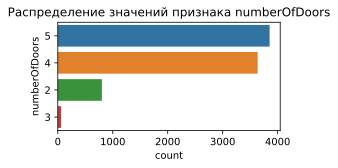

In [25]:
# numberOfDoors
getCountPlot(data,'numberOfDoors', 4, 2)

In [26]:
# vehicleConfiguration
data['vehicleConfiguration'].value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0      1292
SEDAN AUTOMATIC 2.0                 941
SEDAN AUTOMATIC 3.0                 631
ALLROAD_5_DOORS AUTOMATIC 2.0       524
ALLROAD_5_DOORS ROBOT 2.0           226
                                   ... 
SEDAN AUTOMATIC 5.8                   1
HATCHBACK_3_DOORS AUTOMATIC 1.8       1
MINIVAN AUTOMATIC 5.0                 1
MINIVAN MECHANICAL 2.3                1
SEDAN AUTOMATIC 3.8                   1
Name: vehicleConfiguration, Length: 312, dtype: int64

In [27]:
# все параметры упоминаются в других столбцах. удалим
data.drop(['vehicleConfiguration'], axis=1, inplace=True)

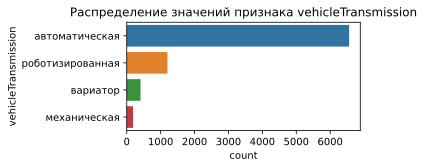

In [28]:
# vehicleTransmission
getCountPlot(data,'vehicleTransmission', 4.2, 2)

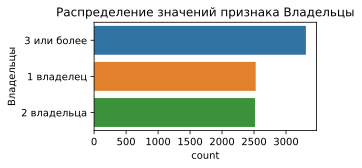

In [29]:
# Владельцы
getCountPlot(data,'Владельцы', 4, 2)

In [30]:
# Владение
data['Владение'].value_counts()

1 год и 8 месяцев     67
1 год и 2 месяца      67
1 год                 55
2 года и 2 месяца     52
9 месяцев             52
                      ..
11 лет и 6 месяцев     1
15 лет и 3 месяца      1
18 лет и 9 месяцев     1
17 лет и 5 месяцев     1
14 лет и 8 месяцев     1
Name: Владение, Length: 180, dtype: int64

In [31]:
# больше половины значений пустые. удалим
data.drop(['Владение'], axis=1, inplace=True)

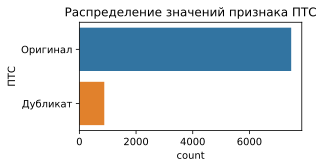

In [32]:
# ПТС
getCountPlot(data,'ПТС', 4, 2)

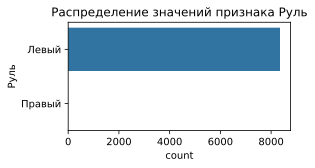

In [33]:
# Руль
getCountPlot(data,'Руль', 4, 2)

In [34]:
# нет вариативности признака. удалим
data.drop(['Руль'], axis=1, inplace=True)

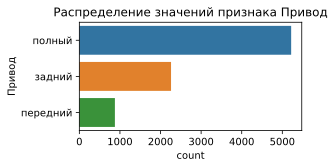

In [35]:
# Привод
getCountPlot(data,'Привод', 4, 2)

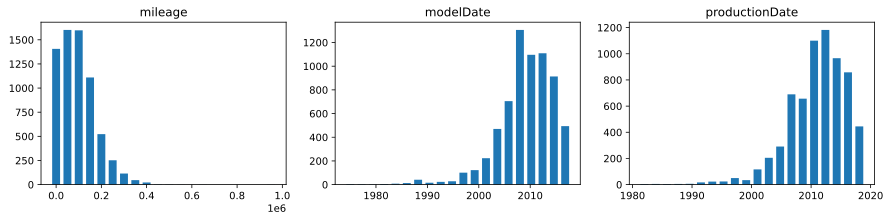

In [36]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 5, rows * 3))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

In [37]:
# избавимся от выбросов
emission_replacement(data, 'mileage', method='median')

In [38]:
# добавим призанки 
# лет в использовании
data['years_in_use'] = 2021 - data['productionDate']
# количество пробега за год
data['mileage_per_year'] = data['mileage'] / data['years_in_use']

In [39]:
#создали список категориальных
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', '4wd', 'xdrive', 'numberOfDoors',
                        'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод']

#cоздали список числовых признаков
numerical_features = ['productionDate','modelDate', 'mileage',
                     'years_in_use', 'mileage_per_year', 'enginePower', 'engineDisplacement']

In [40]:
#логарифмируем числовые признаки

for col in data[numerical_features]:
    data[col] = data[col].apply(lambda x: np.log(x) if x>0 else x)

In [41]:
def preproc_data(df_input):
    '''функция для удаления лишний признаков, энкодингов'''
    
    df_output = df_input.copy()
    
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id'], axis = 1, inplace=True)
    
     
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)

    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    
    return df_output

# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,years_in_use,mileage_per_year,bodyType_0,...,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
3640,0.467888,0.439126,0.969621,0.772949,0.686257,1,630000.0,0.700125,0.898617,0,...,1,0,1,0,0,0,1,0,0,1
6421,0.467888,0.310328,0.942288,0.793642,0.791046,1,680000.0,0.599751,0.900322,0,...,0,0,0,1,0,0,1,1,0,0
7645,0.420931,0.339223,0.902436,0.752247,0.712474,1,599000.0,0.678276,0.834566,0,...,0,0,0,1,0,0,1,0,1,0
7222,0.467888,0.529985,0.823817,0.917580,0.895627,1,2150000.0,0.439310,0.824373,0,...,0,0,0,1,0,0,1,0,0,1
4604,0.648598,0.553132,0.927132,0.793642,0.791046,1,1290000.0,0.599751,0.884377,0,...,0,0,0,1,0,0,1,0,0,1
5140,0.275896,0.310328,0.732741,0.979410,0.973926,1,1898000.0,0.189200,0.804457,0,...,1,0,1,0,0,0,1,0,1,0
728,0.420931,0.339223,0.942987,0.752247,0.764868,0,0.0,0.628510,0.892330,0,...,0,0,0,0,1,0,1,0,1,0
7029,0.567340,0.477709,0.903261,0.648579,0.633785,1,675000.0,0.739185,0.816950,0,...,0,0,1,0,0,0,1,1,0,0
1997,0.648598,0.629523,0.971437,0.752247,0.712474,1,970000.0,0.678276,0.907158,0,...,0,0,0,0,1,0,1,0,0,1
3433,0.467888,0.463097,0.943481,0.834995,0.791046,1,890000.0,0.599751,0.901576,0,...,1,0,0,0,1,0,1,0,0,1


In [42]:
# логарифмируем целевую переменную
df_preproc['price'] = data['price'].apply(lambda x: np.log(x) if x>0 else x)

## Split data

In [43]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

### CatBoostRegressor

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

После нескольких экспериментов оставил learning rate=0.05, дает лучее значение метрики

In [45]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.05,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.0410066	test: 0.0410784	best: 0.0410784 (0)	total: 53.7ms	remaining: 4m 28s
100:	learn: 0.0103281	test: 0.0100904	best: 0.0100904 (100)	total: 407ms	remaining: 19.7s
200:	learn: 0.0092956	test: 0.0092023	best: 0.0092023 (200)	total: 750ms	remaining: 17.9s
300:	learn: 0.0086078	test: 0.0087399	best: 0.0087399 (300)	total: 1.09s	remaining: 17s
400:	learn: 0.0080758	test: 0.0083873	best: 0.0083873 (400)	total: 1.42s	remaining: 16.3s
500:	learn: 0.0076829	test: 0.0081581	best: 0.0081581 (500)	total: 1.74s	remaining: 15.6s
600:	learn: 0.0074037	test: 0.0080056	best: 0.0080056 (600)	total: 2.06s	remaining: 15.1s
700:	learn: 0.0071940	test: 0.0079027	best: 0.0079027 (700)	total: 2.4s	remaining: 14.8s
800:	learn: 0.0070080	test: 0.0078307	best: 0.0078307 (800)	total: 2.72s	remaining: 14.3s
900:	learn: 0.0068301	test: 0.0077754	best: 0.0077754 (900)	total: 3.04s	remaining: 13.9s
1000:	learn: 0.0066482	test: 0.0077290	best: 0.0077265 (997)	total: 3.37s	remaining: 13.5s
1100:	learn: 0

In [46]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 11.03%


TEST mape: TEST mape: 11.03%

### Submission

In [47]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_catboost)
sample_submission.to_csv('catboost_submission.csv', index=False)

# Tabular NN

Построим обычную сеть:

In [48]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,years_in_use,mileage_per_year,bodyType_0,bodyType_1,bodyType_2,...,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
7320,0.957522,0.887119,0.938399,0.772949,0.764868,0.628510,0.887503,0,0,0,...,0,0,1,0,0,0,1,1,0,0
8037,0.467888,0.529985,0.783379,0.938200,0.947839,0.299875,0.824144,0,1,0,...,0,0,1,0,0,0,1,0,0,1
4681,0.663211,0.547896,0.929458,0.690077,0.633785,0.739185,0.844511,0,0,0,...,0,0,0,0,1,0,1,0,0,1
6014,0.420931,0.401796,0.914253,0.731534,0.660028,0.720353,0.834230,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3649,0.648598,0.639649,0.924671,0.834995,0.817211,0.567601,0.891545,0,0,0,...,0,0,1,0,0,0,1,0,0,1


## Simple Dense NN

In [49]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [50]:
# model.summary()

In [51]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [52]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' ,save_best_only=True, monitor='val_MAPE', verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [53]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

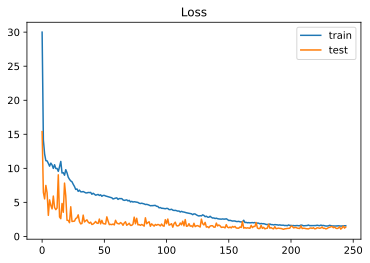

In [54]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [55]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [56]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn1[:,0])))*100:0.2f}%")

TEST mape: 14.88%


TEST mape: 13.49%

# Проведем эксперимент с простой нейронной сетью, добавим батчнормализацию в модель

In [57]:
from tensorflow.keras.layers import BatchNormalization

In [58]:
import tensorflow.keras.backend as K

In [59]:
K.clear_session() # очищаем сессию keras

In [60]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               97792     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [62]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [63]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' ,save_best_only=True, monitor='val_MAPE', verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]


In [64]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

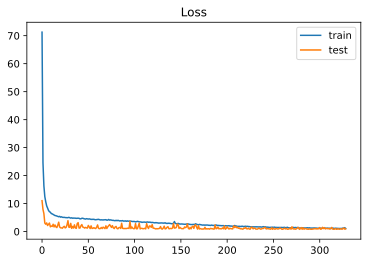

In [65]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [66]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [67]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn1[:,0])))*100:0.2f}%")

TEST mape: 11.41%


TEST mape: 11.07%

Добавление батчнормализации позволило улучшить метрику с 14% до 12%

Попробуем поработать с learning rate:

In [68]:
from tensorflow.keras import regularizers

In [69]:
K.clear_session() # очищаем сессию keras

In [70]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1],  kernel_regularizer=regularizers.l1_l2(l1=0.000000001, 
        l2=0.000000001), activation="relu"))
model.add(BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(256,kernel_regularizer=regularizers.l1_l2(l1=0.000000001, 
        l2=0.000000001), activation="relu"))
model.add(BatchNormalization())
model.add(L.Dropout(0.5))

model.add(L.Dense(1, activation="linear"))

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               97792     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [72]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [73]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor='val_MAPE',save_best_only=True, verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [74]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

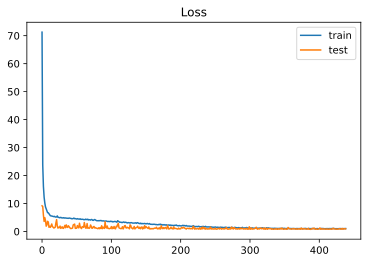

In [75]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [76]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [77]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn1[:,0])))*100:0.2f}%")

TEST mape: 11.36%


Четкой разницы не видно, эксперимент не удался, но по идее можно еще попробовать подобрать LR таким образом чтобы улучшить метрику

Объединим предсказания нейронной сети и catboost путем усреднения:

In [78]:
# попробуем объединить предсказания catboost и нейронной сети
new_pred = (test_predict_catboost + test_predict_nn1[:,0])/2
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(new_pred)))*100:0.2f}%")

TEST mape: 10.70%


TEST mape: 10.93%

Очень даже неплохо, минимум трудозатрат, а метрика улучшилась, сделаем сабмит этой парочки

In [79]:
# сабмит для нейронной сети отдельно
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_nn1[:,0])
sample_submission.to_csv('nn1_submission.csv', index=False)

In [80]:
sample_submission['price'] = (np.exp(sub_predict_nn1[:,0])+np.exp(sub_predict_catboost))/2
sample_submission.to_csv('nn1+cat_submission.csv', index=False)

В итоге комбинация Catboost и простой нейросети улучшили результаты на каггле с 12.4 до 12.3, неплохо)

# Model 4: NLP + Multiple Inputs

In [81]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [82]:
# TOKENIZER
# максимальное количество слов использовано
MAX_WORDS = 100000
# максимальное количество слов в строке
MAX_SEQUENCE_LENGTH = 256

In [83]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [84]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 1.49 s


In [85]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [86]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.46 s, sys: 0 ns, total: 1.46 s
Wall time: 1.46 s


In [87]:
text_train.iloc[0]

'Требуется замена форсунок и рулевой рейки( ремонт либо замена). \nПИСАТЬ на what’s up !!!на левые звонки не отвечаю. Писать на whatsup , перезвоню сам.\n******************'

In [88]:
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

Построим сеть с двумя входами: сеть обучающаяся на текстовой информации и сеть обучающаяся на наших табличных значениях.

In [89]:
K.clear_session() # очищаем сессию keras

In [90]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

In [91]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

Общая голова, принимает на вход выходы первых двух сетей

In [92]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [93]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

In [94]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [95]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [96]:
history = model.fit([text_train_sequences, X_train], np.exp(y_train),
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test],np.exp(y_test)),
                    callbacks=callbacks_list
                   )


Epoch 1/500
12/12 [==============================] - 5s 442ms/step - loss: 99.9780 - MAPE: 99.9780 - val_loss: 99.7469 - val_MAPE: 99.7469
Epoch 2/500
12/12 [==============================] - 5s 385ms/step - loss: 97.9064 - MAPE: 97.9064 - val_loss: 90.6500 - val_MAPE: 90.6500
Epoch 3/500
12/12 [==============================] - 4s 375ms/step - loss: 71.9163 - MAPE: 71.9163 - val_loss: 50.1917 - val_MAPE: 50.1917
Epoch 4/500
12/12 [==============================] - 5s 391ms/step - loss: 52.1592 - MAPE: 52.1592 - val_loss: 46.9092 - val_MAPE: 46.9092
Epoch 5/500
12/12 [==============================] - 4s 358ms/step - loss: 46.7584 - MAPE: 46.7584 - val_loss: 44.2427 - val_MAPE: 44.2427
Epoch 6/500
12/12 [==============================] - 5s 393ms/step - loss: 44.0244 - MAPE: 44.0244 - val_loss: 41.8389 - val_MAPE: 41.8389
Epoch 7/500
12/12 [==============================] - 4s 361ms/step - loss: 41.5985 - MAPE: 41.5985 - val_loss: 39.2901 - val_MAPE: 39.2901
Epoch 8/500
12/12 [========

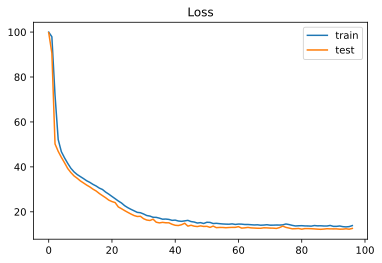

In [97]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [98]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.20%


TEST mape: 12.02%

 Сложная сеть дала на выходе неплохую метрику.Так же сделаем сабмит из объединения результатов для этой сети  и catboost:

In [99]:
sub_predict_nn2 = model.predict([text_sub_sequences,X_sub])

In [100]:
sub_predict_nn2 = model.predict([text_sub_sequences,X_sub])
sample_submission['price'] = (sub_predict_nn2[:,0]+np.exp(sub_predict_catboost))/2

In [101]:
sample_submission.to_csv('nn2+cat_submission.csv', index=False)

нейросеть, с обработкой текста + простая нейросеть и catboost в итоге дали пока что лучшую точность на каггле 11.797!

Эксперимент берем исправленную мной нейросеть, и текстовую, + результаты catboost

In [102]:
K.clear_session() # очищаем сессию keras

In [103]:
# TOKENIZER
# максимальное количество слов использовано
MAX_WORDS = 100000
# максимальное количество слов в строке
MAX_SEQUENCE_LENGTH = 256

In [104]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [105]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 2.27 s


In [106]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.45 s, sys: 0 ns, total: 1.45 s
Wall time: 1.45 s


In [107]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

In [108]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [109]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [110]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [111]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [112]:
history = model.fit([text_train_sequences, X_train], np.exp(y_train),
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test],np.exp(y_test)),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 5s 420ms/step - loss: 97.2209 - MAPE: 97.2209 - val_loss: 87.0356 - val_MAPE: 87.0356
Epoch 2/500
12/12 [==============================] - 5s 384ms/step - loss: 61.7198 - MAPE: 61.7198 - val_loss: 36.3686 - val_MAPE: 36.3686
Epoch 3/500
12/12 [==============================] - 5s 417ms/step - loss: 38.0911 - MAPE: 38.0911 - val_loss: 32.9148 - val_MAPE: 32.9148
Epoch 4/500
12/12 [==============================] - 5s 412ms/step - loss: 32.3475 - MAPE: 32.3475 - val_loss: 27.7781 - val_MAPE: 27.7781
Epoch 5/500
12/12 [==============================] - 5s 394ms/step - loss: 28.1000 - MAPE: 28.1000 - val_loss: 25.4683 - val_MAPE: 25.4683
Epoch 6/500
12/12 [==============================] - 5s 401ms/step - loss: 25.3029 - MAPE: 25.3029 - val_loss: 21.5567 - val_MAPE: 21.5567
Epoch 7/500
12/12 [==============================] - 5s 375ms/step - loss: 23.4259 - MAPE: 23.4259 - val_loss: 19.8017 - val_MAPE: 19.8017
Epoch 8/500
12/12 [========

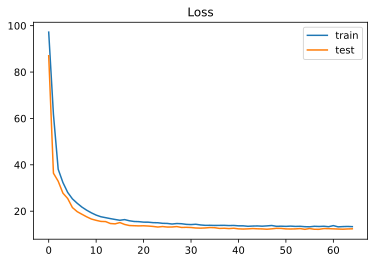

In [113]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [114]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.18%


TEST mape: 12.28%

Попробуем засабмитить результат с усредниением catboost

In [115]:
sub_predict_nn2 = model.predict([text_sub_sequences,X_sub])
sample_submission['price'] = (sub_predict_nn2[:,0]+np.exp(sub_predict_catboost))/2

In [116]:
sample_submission.to_csv('nn2_exp+cat_submission.csv', index=False)

Это лучшая точность на kaggle 11.755!

### Добавляем картинки

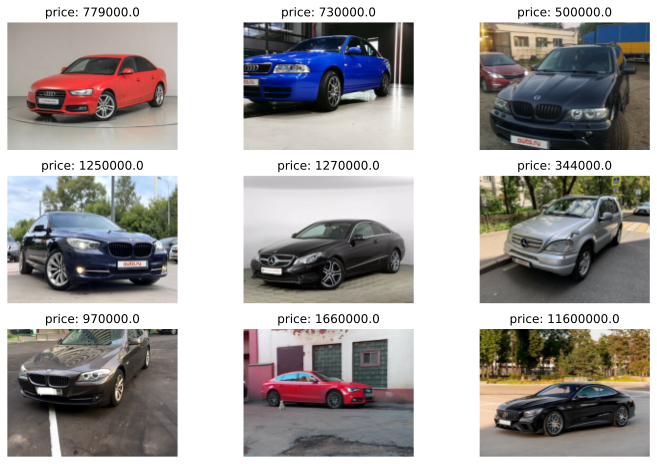

In [117]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [118]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


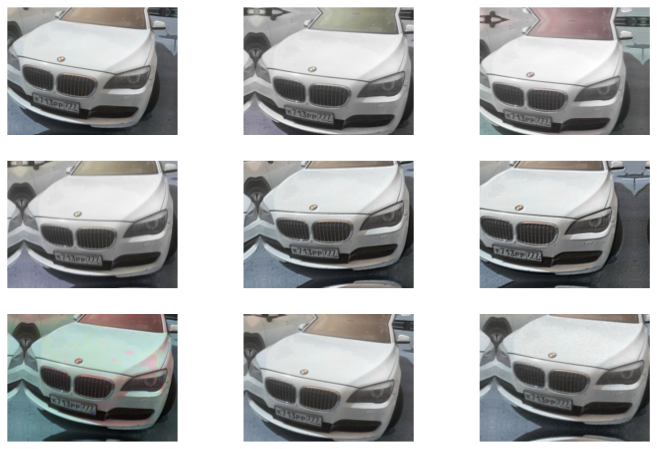

In [119]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
   # HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.02, rotate_limit=5, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [120]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [121]:
# TOKENIZER
# максимальное количество слов использовано
MAX_WORDS = 100000
# максимальное количество слов в строке
MAX_SEQUENCE_LENGTH = 256

# Лемматизируем и удалим стоп слова
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

def preprocess_text(text):
    """функция для предобработки текста"""
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
             and token != " " \
             and token.strip() not in punctuation]
    text = " ".join(tokens)

    return text

#df_preproc['description_preproc'] = data['description'].apply(preprocess_text)
df_preproc['description_preproc'] = data['description']


# split данных
#text_train = df_preproc.description_preproc.iloc[X_train.index]
#text_test = df_preproc.description_preproc.iloc[X_test.index]
#text_sub = df_preproc.description_preproc.iloc[X_sub.index]

#%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df_preproc.description_preproc)
#tokenize.word_index



Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


Качество модели после препроцессинга description, стало хуже

In [122]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, df_preproc['description_preproc'].iloc[X_train.index], np.exp(y_train)
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, df_preproc['description_preproc'].iloc[X_test.index], np.exp(y_test)
    )).map(tf_process_val_dataset_element)
y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, df_preproc['description_preproc'][X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [123]:
# Строим сверточную сеть для анализа изображений без "головы"
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [124]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [125]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [126]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
#model.summary()

In [127]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [128]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [129]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list)

Epoch 1/100
190/190 [==============================] - 149s 782ms/step - loss: 54.2678 - MAPE: 54.2678 - val_loss: 36.9087 - val_MAPE: 36.9087
Epoch 2/100
190/190 [==============================] - 145s 763ms/step - loss: 34.6866 - MAPE: 34.6866 - val_loss: 32.6405 - val_MAPE: 32.6405
Epoch 3/100
190/190 [==============================] - 146s 768ms/step - loss: 29.9879 - MAPE: 29.9879 - val_loss: 26.3277 - val_MAPE: 26.3277
Epoch 4/100
190/190 [==============================] - 144s 760ms/step - loss: 24.7463 - MAPE: 24.7463 - val_loss: 23.3726 - val_MAPE: 23.3726
Epoch 5/100
190/190 [==============================] - 145s 764ms/step - loss: 21.1522 - MAPE: 21.1522 - val_loss: 17.8106 - val_MAPE: 17.8106
Epoch 6/100
190/190 [==============================] - 146s 767ms/step - loss: 19.0974 - MAPE: 19.0974 - val_loss: 15.7663 - val_MAPE: 15.7663
Epoch 7/100
190/190 [==============================] - 145s 763ms/step - loss: 17.7728 - MAPE: 17.7728 - val_loss: 14.6966 - val_MAPE: 14.6966

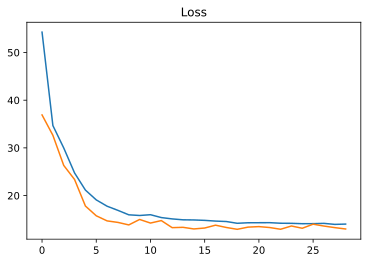

In [130]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [131]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [132]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.00%


TEST mape: 13.15%  - такой результат удалось получить немного изменив параметры аугментации изображений. А именно: Убрал HorisontalFlip,  изменил параметры ShiftScaleRotate( shift_limit = 0.1/0.0625
                                                                   scale_limit = 0.02/0.2
                                                                   rotate_limit = 5/15)
                                                                   
С настройками baseline TEST mape у этой модели получался 13.84% 

In [133]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

Эксперимент Multi-input  сеть: табличные данные+текст+ картинки  с использованием  NNсети с батчнорм

In [134]:
K.clear_session() # очищаем сессию keras

In [135]:
# Строим сверточную сеть для анализа изображений без "головы"
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [136]:
#строим нейросеть для анализа табличных данных
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [137]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [138]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
#model.summary()

In [139]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [140]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [141]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list)

Epoch 1/100
190/190 [==============================] - 152s 798ms/step - loss: 34.8032 - MAPE: 34.8032 - val_loss: 16.7964 - val_MAPE: 16.7964
Epoch 2/100
190/190 [==============================] - 147s 771ms/step - loss: 17.3959 - MAPE: 17.3959 - val_loss: 14.7347 - val_MAPE: 14.7347
Epoch 3/100
190/190 [==============================] - 151s 793ms/step - loss: 15.8259 - MAPE: 15.8259 - val_loss: 14.3786 - val_MAPE: 14.3786
Epoch 4/100
190/190 [==============================] - 145s 765ms/step - loss: 14.8723 - MAPE: 14.8723 - val_loss: 13.2825 - val_MAPE: 13.2825
Epoch 5/100
190/190 [==============================] - 145s 762ms/step - loss: 14.4200 - MAPE: 14.4200 - val_loss: 42.3641 - val_MAPE: 42.3641
Epoch 6/100
190/190 [==============================] - 146s 771ms/step - loss: 14.4204 - MAPE: 14.4204 - val_loss: 14.1391 - val_MAPE: 14.1391
Epoch 7/100
190/190 [==============================] - 146s 768ms/step - loss: 14.1252 - MAPE: 14.1252 - val_loss: 13.2133 - val_MAPE: 13.2133

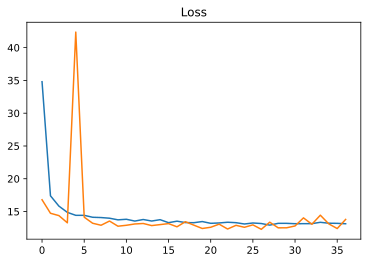

In [142]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [143]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [144]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.80%


TEST mape: 12.69%

Метрика на тесте несколько улучшилась, но все - таки эта модель по качеству уступает более простой без картинок.

### Blend

In [145]:
blend_predict = (np.exp(test_predict_catboost) + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(np.exp(y_test), blend_predict))*100:0.2f}%")

TEST mape: 11.09%


TEST mape: 10.84%


In [146]:
blend_sub_predict = (np.exp(sub_predict_catboost) + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

Метрика  на Kaggle 11.91  тоже несколько у ступает лучшему результату модели с табличными и с текстовыми данными

****Итог****

Выводы: 
в EDA
- Данные очищены от пропусков, пустые значения заменены на медианы
- Признаки с большим количеством пропусков или не имеющие распределения относительно целевой переменной( прим"Руль") удалены
- Сформированы новые признаки feature engeneering
- Данные прологарифмированы и нормированы для подачи более качественного материала в модели обучения

Модели:
- Построена наивная модель, для того  чтобы в дальнейшем понимать куда мы двигаемся (улучшение/ухудшение метрики)
- Обучена модель на основе Catboost. Настроены гиперпараметры, лучше всего себя показал LR = 0.05 MAPE = 11.03%
- Обучена модель на основе простой нейросети, неплохой результат дали эксперименты с добавлением Batchnormalisation, улучшили значение метрики
-Построена Multi-input  сеть: табличные данные+текст. Сеть работающая с табличными данными дополнена батчнормализацией из прошлых экспериментов, это повысило результат комбинации
-Построена Multi-input  сеть: табличные данные+текст+ картинки . Эксперимент пока идет, изменил некоторые параметры аугментации, надо бы еще на вход вместо обычной нейронной сети подать мой вариант
- К моделям, построенным на основе нейросетей применен блендинг Catboost. В итоге это и дало лучшие результваты на сабмитах, лучший сабмит на Kaggle 11.75(Multi-input  сеть: табличные данные+текст+ CatBoost - лучший результат). Таким образом удалось улучшить baseline проекта

Что еще можно было сделать:
 - Думаю если поработать еще над текстовой информацией и подать на обучение нейросети более качественную инфу, то в итоге мы получим лучшую метрику для Multi-input  сеть: табличные данные+текст, потенциал там еще есть, не хваатает мозгов
 - Для модели  Multi-input  сеть: табличные данные+текст+ картинки  требуется очень много времени. Возможно в результате удастся добиться лучших результатов чем по другим, более простым сетям. Думаю стоит еще поработать с аугментацией, при правильных настройках качество еще значительно возрастет. Но картинки оборабатываются очень долго, соответственно время экспреиментов вырастает в разы, а прироста относительно базовой модели мне удалось достичь совсем небольшого.
Общий вывод: при ограниченных сроках лучше строить простые модели и комбинируя их ( в данном проекте использован блендинг) можно в короткие сроки добиваться результатов, сравнимых с работой тяжелых нейросетей.
